# 14 - Panel Data and Fixed Effects

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel

%matplotlib inline
pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

이전 챕터에서, 실험군과 대조군(각각 POA와 FLN)과 2개의 기간(Intervention 전후)이 있는 기본적인 DID에 필요한 가정과 적용방법에 대해 배웠습니다. 만약에 더 많은 기간과 3개 이상의 그룹인 경우에 대해 인과효과를 추정하기 위해서는 어떻게 해야 할까요? DID의 설정은 인과추론을 적용하는데 있어 매우 일반적이며, 강력하다보니 이에 대한 자체적인 용어도 있습니다. 바로 패널 데이터(Panel data)인데요, 패널은 여러 기간에 걸쳐 동일한 단위(unit)를 반복적으로 관찰한 경우입니다. 패널 데이터는 여러 해에 걸쳐 여러 도시 또는 주에 대한 데이터를 추적할 수 있는 정부 정책 평가에서 많이 발생합니다. 패널 데이터는 정부 관련 뿐만 아니라, 기업들이 몇 주 또는 몇 달에 걸쳐 유저 데이터를 추적하는 산업에서도 매우 일반적으로 볼 수 있어요.

패널 데이터 구조를 활용하는 방법을 이해하기 위해, 먼저 POA(Porto Alegre)시에 광고판을 배치할 때(Treatment)의 영향을 추정하고자 했던 DID 예제를 계속 진행해보도록 할게요. 이 예시에서는 오프라인 마케팅 전략이 투자 상품의 활용도를 높일 수 있는지 파악하고자 했습니다. 특히, 광고판을 설치하면 투자 계좌의 예금이 얼마나 증가하는지 알고 싶었던 것이죠.

이전 챕터에서, 광고판을 배치하지 않았다면 Porto Alegre에 어떤 일이 일어났을지에 대한 대체 전략(Imputation strategy)으로 DID 추정량을 활용했어요. Porto Alegre **개입 후**(광고판 배치)에 대한 반사실 결과 $Y_0$는 **개입 전** Porto Alegre의 예금수에 성장 요인(growth factor)을 더한 값으로 볼 수 있다고 했었습니다. 참고로 이 성장 요인은 대조군인 Florianopolis(FLN) 시에서 추정되었습니다. 몇 가지 표기법 요약을 통해, 어떻게 반사실 결과를 추정할 수 있는지 다음과 같이 나타내보겠습니다.

$$
\underbrace{\widehat{Y_0(1)|D=1}}_{\substack{\text{POA outcome after intervention}} \\ \substack{\text{if no intervention had taken place}}} 
= \underbrace{Y_0(0)|D=1}_{\substack{\text{POA outcome}} \\ \substack{\text{before intervention}}} 
+ \big( \underbrace{Y_0(1)|D=0}_{\substack{\text{FLN outcome after}} \\ \substack{\text{intervention in POA}}} 
- \underbrace{Y_0(0)|D=0}_{\substack{\text{FLN outcome before}} \\ \substack{\text{intervention in POA}}} \big)
$$

여기서 $t$는 시간을 나타내고, $D$는 처치($t$를 사용하기 때문에)를 나타내며, $Y_D(t)$는 $t$ 기간의 처치 $D$에 대한 잠재적 결과(potential outcome)를 나타냅니다(예시 : $Y_0(1)$는 기간이 1 일 때, 대조군에 대한 결과). 이제 counterfactual에 대한 대체적인 잠재적 결과를 취하면 다음과 같이 POA에 대한 처치 효과(ATT)를 표현할 수 있어요.
 
$$
\widehat{ATT} = \underbrace{Y_1(1)|D=1}_{\substack{\text{POA outcome} \\ \text{after intervention}}} - \widehat{Y_0(1)|D=1}
$$

즉, 광고판을 POA에 배치하는 효과는 광고판을 배치한 후, POA에서 측정한 결과에서 광고판을 배치하지 않았다면 일어날 일에 대한 추정치를 뺀 것에 해당해요. 또한 DID의 핵심은 위에서 언급된 반사실을 추정하기 위해, POA에서의 예금의 증가가 FLW의 예금 증가와 일치해야 한다는 사실에서 비롯된다는 사실을 명심해야 해요. 이 부분이 바로 DID에 핵심인 평행 추세 가정(parallel trends assumption)입니다. 평행 추세 가정은 나중에 매우 중요한 부분을 차지하기 때문에 이번에 확실하게 배워봅시다.

## Parallel Trends
 
평생 추세 가정을 보는 한 가지 방법은 독립성 가정(Independence assumption)입니다. 초반에 학습한 챕터를 떠올려보면, 독립성 가정은 처치 할당(treatment assign)이 잠재적 결과로부터 독립적이어야 합니다:

$$
Y_d \perp  D
$$

해당 가정은 더 높은 결과(효과 추정에서 상승 편향을 일으킬 수 있음) 또는 더 낮은 결과(하향 편향을 유발함)를 가진 대상에 더 많은 treatment를 주지 않는다는 것을 의미해요. 조금 구체적으로 설명하자면, 마케팅 매니저가 이미 은행 예금이 매우 높은 도시에만 광고판을 추가하기로 결정했다고 가정해 볼게요. 그렇게 하면 나중에 광고판이 있는 도시가 더 많은 예금을 만들었다고 자랑할 수 있게 됩니다. 물론 마케팅 캠페인은 성공적이었겠죠. 도덕적 논의를 제쳐두고, 이 부분이 독립성 가정을 위반한다는 것을 알 수 있을 거에요: $Y_0$가 높은 도시에 treatment를 주는 것이죠. 또한 독립성 가정의 자연스러운 확장은 조건부 독립에 대한 가정으로 이어집니다. 잠재적 결과가 처음에는 treatment에 종속되지만 교란변수 $X$를 condition하게 된다면 독립적 조건부 독립 가정이 됩니다.

$
Y_d \perp D | X
$
 
그런데, 독립성 가정이 DID와 평행 추세 가정과 정확히 어떻게 연결될까요? 클래식한 독립성 가정에서 treatment assignment 잠재적 결과의 **수준(levels)**과 관련될 수 없다고 되어 있는 경우, 평행 추세 가정은 treatment assignment이 잠재적 결과의 시간에 따른 **성장(growth)**과 관련될 수 없다고 말하고 있어요. 평행 추세 가정을 작성하는 한 가지 방법은 다음과 같습니다.

$
\big(Y_d(t) - Y_d(t-1) \big)  \perp D
$
 
조금 덜 수학적으로는, 이 조건부 독립 가정은 결과 수준이 높거나 낮은 대상에 treatment를 할당하는 것이 괜찮다고 이야기하고 있습니다. 이 가정에서는 결과가 어떻게 증가하는지에 따라 treatment를 실험 대상에 할당할 수 없게 됩니다. 가정은 앞서 살펴본 광고판 예시에서 원래 예금 수준이 높은 도시에만 광고판을 배치하는 것이 좋다는 것을 의미합니다. 반면, 예금이 가장 많이 증가하는 도시에만 광고판을 배치할 수 없다고 말하고 있어요. DID가 대조군의 추세와 함께 실험군의 counterfactual 추세를 input으로 한다는 것을 기억한다면 해당 가정은 많은 의미가 있어요. 통제하에 있는 실험군의 추세가 대조군의 추세와 다른 경우, 앞서 말한 가정에서 문제가 생기게 됩니다.

## Controlling What you Cannot See
 
성향 점수, 선형 회귀 및 매칭과 같은 방법은 랜덤하지 않은 데이터(non-random data)의 교란변수를 통제하는 ​​매우 좋은 방법입니다. 하지만, 해당 방법들은 중요한 가정인 conditional unconfoundedness에 의존합니다.
 
$
(Y_0, Y_1) \perp T | X
$

한마디로 말하면, 해당 방법들은 모든 교란변수를 알고있고 측정이 되어야, 교란변수를 조건부로 두고 random assignment와 같이 treatment를 구성 할 수 있습니다. 그런데, 이 부분에 대한 한가지 중요한 문제는 교란변수를 항상 측정(관측) 할 수 없는 경우가 존재합니다. 예를 들어, 결혼이 남성의 수입에 미치는 영향을 알아내는 고전적인 노동 경제학 문제를 생각해 보시죠. 기혼 남성이 미혼 남성보다 더 많이 번다는 것은 경제학에서 잘 알려진 사실입니다. 그러나 이 관계가 인과관계인지 아닌지는 분명하지 않아요. 교육 수준이 높은 남성이 결혼할 가능성 및 높은 수입을 가질 가능성이 둘다 높을 수 있어요. 즉, 이 부분은 교육이 수입에 대한 결혼의 영향을 교란효과임을 의미합니다. 해당 경우에는 교란변수에 대해, 실험에 참여한 사람의 교육 수준을 측정하고 이를 통제하는 ​​회귀 분석을 실행해볼 수 있습니다. 그러나, 교육 이외의 또 다른 교란변수는 beauty (외모)가 될 수 있습니다. 더 잘생긴 남자는 결혼할 가능성 및 높은 보수를 주는 직업을 가질 가능성이 더 높을 수 있어요. 아쉽게도, 교란변수로 볼 수 있는 외모는 지능과 같이 정량화하기 어려운 특성 중 하나입니다. 

측정되지 않은 교란 변수가 있으면 bias가 존재하기 때문에, 인과효과 추정에 어려운 상황에 놓이게 됩니다. 교란변수를 효과적으로 처리하는 한 가지 방법은 이전에 다룬 것처럼 도구변수를 사용하는 것입니다. 하지만, 좋은 도구변수를 만드는 것은 쉬운일이 아니며, 많은 창의성을 요구해요. 그래서 해당 챕터에서는 도구변수 대신, 패널 데이터 구조를 활용해 보겠습니다.

앞서 어떻게 패널 데이터가 unconfoundedness 가정을 평행 추세 가정으로 대체 가능하게 해주는 부분을 살펴 보았습니다. 그러나 패널 데이터를 이용한 방법이 측정되지 않은 교란변수를 다루는데 어떻게 도움이 될까요? 먼저, 시간이 지남에 따라 반복된 관찰이 있는 설정을 나타내는 인과 그래프를 보도록 할게요. 이 부분에서 4개의 기간에 걸쳐 동일한 관찰을 추적합니다. 결혼(처치)과 소득(결과)은 시간이 지남에 따라 변합니다. 구체적으로, 결혼은 기간 3과 4에 나타나고 (0에서 1로) 같은 기간에 소득이 증가합니다. 측정할 수 없는 교란변수 beauty는 모든 기간에 걸쳐 동일합니다 (과감한 표현이지만 기간이 불과 몇 년정도면 사람의 외모는 일반적으로 크게 변하지 않으니 합리적이라고 볼 수 있어요). 그렇다면 소득이 늘어나는 이유가 단순히 교란변수인 beauty의 증가 때문이 아니라 결혼 때문이라는 것을 어떻게 알 수 있을까요? 그리고 더 중요한 건 볼 수 없는 교란변수에 대해 어떻게 통제할 수 있을까요?
 
![img](./data/img/fixed-effects/fe-graph.png)
 
여기서 사용해볼 요령은 실험 대상을 확대하고 시간이 지남에 따라 대상이 어떻게 발전하는지 추적해서, 시간에 따라 고정된 모든 것을 이미 통제하고 있음을 확인하는 것입니다. 이 부분에서 시간에 대해 고정되어있고 측정되지 않은 교란 변수가 포함됩니다. 예를 들어 위의 그래프에서 시간에 따라 소득이 증가하는 것이 단순히 외모가 동일하게 유지되기 때문에(결국 시간이 고정되어 있기 때문에) 외모가 좋아진 것 때문이 아님을 이미 알 수 있습니다. 결론은 외모라는 변수를 제어할 수는 없고 측정할 수 없으므로, 패널 구조를 계속 사용할 수 있게되어 더 이상 문제가 되지 않는다는 것입니다.
 
패널 구조에서 교란변수를 바라보는 또 다른 방법은 시간에 고정된 (time fixed) 교란변수를 각 실험대상에 고유한 속성으로 생각하는 것입니다. 이 부분은 인과 그래프에 중간 단위 노드를 추가하는 것과 같아요. 이제 실험 대상에 대한 통제가 어떻게 결과와 관찰되지 않은 시간 고정된 교란변수 사이의 backdoor path를 차단하는지 주목해주세요.
 
![img](./data/img/fixed-effects/control-unit.png)
 
잠깐 생각을 해보았을 때, 사람의 외모나 지성과 같은 속성을 측정할 수 없지만 그 특징을 가진 사람은 시간이 흘러도 같은 개인이라는 것을 알고 있습니다. 실제로 이러한 통제를 하는 메커니즘은 매우 간단해요. 여기서 여러분이 해야할 일은 특정 사람을 나타내는 더미 변수를 만들고 선형 모델에 추가하는 것입니다. 즉, 해당 더미변수를 추가함으로, 사람 자체를 제어할 수 있다는 것을 의미하고 있어요. 위에서 설명한 모델에서 사람에 대한 더미변수와 함께 결혼이 소득에 미치는 영향을 추정할 때, 회귀분석은 **사람에 대한 변수를 고정된 상태로 유지하면서** 결혼의 효과를 찾습니다. 그래서, 실험대상에 대한 더미변수를 추가하는 것을 고정효과 모델(fixed effect model)이라고 합니다.

## Fixed Effects

문제를 좀 더 공식화하기 위해, 먼저 가지고 있는 데이터를 한 번 살펴보겠습니다. 앞서 설명드린 예시에 따라 결혼이 소득에 미치는 인과적 영향을 추정하려고 노력할 것입니다. 아래 데이터에는 여러 해 동안 여러 개인(`nr`)에 대한 `married (기혼여부)` 및 `lwage (소득의 로그변환)` 이 2가지 변수가 포함되어 있습니다. 소득은 로그로 변환한 형식입니다. 이 외에도 해당 연도의 근무 시간, 교육 년수 등과 같은 다른 제어할 수 있는 변수가 있습니다.

In [2]:
data = wage_panel.load()
data.head()

,nr,year,black,...,lwage,expersq,occupation
0,13,1980,0,...,1.197540,1,9
1,13,1981,0,...,1.853060,4,9
2,13,1982,0,...,1.344462,9,9
3,13,1983,0,...,1.433213,16,9
4,13,1984,0,...,1.568125,25,5


일반적으로, 고정효과 모델은 아래와 같이 정의됩니다.

$
y_{it} = \beta X_{it} + \gamma U_i + e_{it}
$

여기서 $y_{it}$는 시간 $t$에서 각 실험대상 $i$의 결과이고, $X_{it}$는 시간 $t$에서 실험대상 $i$에 대한 변수들의 벡터입니다. $U_i$는 실험대상 $i$에 대해 관측 불가능한 변수의 집합입니다. 이러한 관측할 수 없는 변수들은 시간이 지남에 따라 변하지 않으므로(가정), 시간 첨자가 없음을 주목해주세요. 마지막으로 $e_{it}$는 오차항입니다. 위 예시에서 $y_{it}$는 임금에 대한 로그변환, $X_{it}$는 결혼 및 경력과 같이 시간에 따라 변하는 관찰 가능한 변수이고 $U_i$는 관찰되지 않지만 각 개인에 대해 일정한 변수입니다 (ex. 외모와 지성).

고정효과 모델과 함께 패널 데이터를 사용하는 것이 실험대상에 대한 더미(dummy)를 추가하는 것만큼 간단하다고 설명드렸던 것을 기억하시나요? 맞는 말이지만, 실제로는 그렇게 하지 않아요. 예를 들어, 백만명의 고객이 있는 데이터 셋을 생각해봅시다. 각 고객에 대해 하나의 더미를 추가하면 백만 개의 열이 생성되고, 이런 결과가 나오는 것은 좋은 방법이 아닐거에요. 대신, 선형 회귀를 2개의 개별 모델로 분할하는 트릭을 사용할 거에요. 이전 챕터에서도 확인하셨겠지만, 지금이 회귀 모델에 대해 요약하기에 좋은 타임인 것 같아요. 변수들의 집한인 $X_1$과 $X_2$가 있는 선형 회귀 모델이 있다고 가정해봅시다.

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

여기서 $X_1$과 $X_2$는 변수 행렬(피쳐당 1개의 행, 관측값당 1개의 열)이고 $\hat{\beta_1}$ 및 $\hat{\beta_2}$는 행 벡터입니다. 아래와 같은 방법을 통해, 똑같은 $\hat{\beta_1}$ 매개변수 값을 얻을 수 있어요.

1. 두 번째 변수 집합에서 $y$ 결과를 회귀 $\hat{y^*} = \hat{\gamma_1} X_2$
2. 두 번째 $\hat{X_1} = \hat{\gamma_2} X_2$의 첫 번째 변수 집합을 회귀
3. 잔차 $\tilde{X}_1 = X_1 - \hat{X_1}$ 및 $\tilde{y}_1 = y_1 - \hat{y^*}$를 구하기
4. 변수 $\hat{y} = \hat{\beta_1} \tilde{X}_1$의 잔차에 대한 결과의 잔차 회귀

마지막 회귀 모델의 매개변수는 모든 변수를 사용해 회귀를 하는 것 결과와 똑같습니다. 그런데, 이 부분이 어떤 도움이 될까요? 실험 대상에 대한 더미변수가 있는 모델의 추정을 2개로 나눌 수 있습니다. 먼저 더미를 사용하여 변수와 결과를 예측합니다. 위에서 설명한 1,2단계 입니다.

이제 더미 변수를 가지고 회귀를 모델링을 하는 것이 해당 더미 변수의 평균을 추정하는 것만큼 간단하다는 것을 기억하시나요? 데이터를 가지고 이 부분이 맞는지 확인해 봅시다. 연도(year) 더미변수에 대한 함수로 임금을 예측하는 모델을 돌려 보겠습니다.

In [3]:
mod = smf.ols("lwage ~ C(year)", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3935,0.022,63.462,0.000,1.350,1.437
C(year)[T.1981],0.1194,0.031,3.845,0.000,0.059,0.180
C(year)[T.1982],0.1782,0.031,5.738,0.000,0.117,0.239
C(year)[T.1983],0.2258,0.031,7.271,0.000,0.165,0.287
C(year)[T.1984],0.2968,0.031,9.558,0.000,0.236,0.358
C(year)[T.1985],0.3459,0.031,11.140,0.000,0.285,0.407
C(year)[T.1986],0.4062,0.031,13.082,0.000,0.345,0.467
C(year)[T.1987],0.4730,0.031,15.232,0.000,0.412,0.534


해당 회귀 모델이 1980년의 평균 소득을 1.3935로, 1981년에는 1.5129(1.3935+0.1194)과 같이 어떻게 예측하는지 봐주세요. 만약 연도별로 평균을 계산한다면, 회귀 모델과 똑같은 결과를 얻게됩니다. (기준 연도인 1980이 y절편임을 기억해주세요. 따라서 해당 연도의 평균 '임금'을 구하려면, 다른 연도의 매개변수에 y절편값을 추가해야 해요.)

In [4]:
data.groupby("year")["lwage"].mean()

year
1980    1.393477
1981    1.512867
1982    1.571667
1983    1.619263
1984    1.690295
1985    1.739410
1986    1.799719
1987    1.866479
Name: lwage, dtype: float64

즉, 패널 데이터의 모든 사람에 대한 평균을 얻으면 본질적으로 다른 변수에 대한 개별 더미에 회귀를 해야해요. 이 부분은 다음과 같은 추정 절차에 대한 의미를 부여합니다.

1. 개별 대상에 대한 평균을 빼는 방식으로 time-demeaned(시간에 대한 차분) 변수 생성:   
$\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$  
$\ddot{X}_{it} = X_{it} -  \bar{X}_i$

2. $\ddot{Y}_{it}$를 $\ddot{X}_{it}$에 회귀

위와 같은 단계를 거치면, 관측되지 않은 $U_i$ 변수가 사라집니다. $U_i$는 시간에 따라 일정하므로 $\bar{U_i}=U_i$가 됩니다. 아래와 같이 2개의 식이 있다고 보면, 

$$
\begin{align}
Y_{it} & = \beta X_{it} + \gamma U_i + e_{it} \\
\bar{Y}_{i} & = \beta \bar{X}_{it} + \gamma \bar{U}_i + \bar{e}_{it} \\
\end{align}
$$

그리고 우리는 1번식에서 2번식을 빼주게 된다면,

$$
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
$$

시간이 지남에 따라 일정한 관측되지 않은 모든 변수들를 제거하는 효과를 가집니다. 정확히 말하면, 관측되지 않은 변수만 사라지는 것은 아니에요. 시간에 일정한 모든 변수가 해당이 됩니다. 이러한 이유로, 시간에 일정한 변수가 더미변수의 선형 조합이 되고 모델이 실행되지 않게되므로, 시간에 따라 일정한 변수를 포함할 수 없게됩니다.

![img](./data/img/fixed-effects/demeaned.png)

어떤 변수가 그런지 확인하기 위해, 개인별로 데이터를 그룹화 해서 표준 편차의 합계를 얻을 수 있어요. 만약 합계가 0이면 변수가 개별 대상에 대해 시간이 지남에 따라 변하지 않음을 의미합니다.

In [5]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

데이터를 보면, 개별 실험대상에 대해 일정하므로 인종과 관련된 더미변수인 `black`와 `hisp` 및 교육 변수를 제거할 필요가 있어요. 그리고 또한 직업 변수를 사용하지 않을 계획입니다. 해당 변수를 사용하지 않는 이유는 결혼이 임금에 미치는 영향을 중재할 것이기 때문입니다(미혼 남성이 더 많은 시간을 요구하는 포지션을 맡을 수 있기 때문입니다). 사용할 변수를 골랐다면, 이제는 해당 변수를 이용해 모델을 추정할 차례입니다.

고정 효과 모델을 돌리기 위해, 먼저 평균 데이터를 가져와 볼게요. 실험 대상별로 모든 것을 그룹화하고 평균을 취해서, 평균 데이터를 만들 수 있어요.

In [6]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


데이터의 평균을 차분하기 위해서는 원본 데이터의 인덱스를 개별 식별자 'nr'로 설정해야해요. 그런 다음에 평균 데이터에서 기존 데이터를 단순히 빼면 됩니다.

In [7]:
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


마지막으로 평균을 뺀 데이터에 대해 고정 효과 모델을 돌릴 수 있게 됩니다.

In [8]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.679e-17,0.005,-1.32e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


고정 효과가 생략된 모든 변수들의 편향을 제거한다고 생각한다면, 위 모델은 결혼이 남성의 임금을 11% 증가시킨다는 것을 의미하고 있어요. 해당 결과는 매우 중요한데요, 여기서 한 가지 고려할 세부 사항은 고정 효과 모델의 경우 표준 오차가 클러스터되어야(clustered) 한다는 것입니다. 따라서 모든 추정을 직접 수행하는 대신(교육학적인 이유로만 유용해요!) 관련 패키지인, `linearmodels`를 사용 및 해당 `cluster_entity` 인자를 True로 설정할 수 있어요.

In [9]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05


파라미터 추정치가 시간 차분 데이터에서 얻은 것과 어떻게 동일한지 확인해주세요. 유일한 차이는 표준 오류가 약간 더 크다는 것입니다. 이제, 데이터의 시간 부분을 고려하지 않은 간단한 OLS 모델과 비교해보겠습니다. 해당 OLS 모델의 경우, 시간에 일정한 변수들을 다시 추가해야 합니다.

In [10]:
mod = smf.ols("lwage ~ expersq+union+married+hours+black+hisp+educ", data=data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2654,0.065,4.103,0.000,0.139,0.392
expersq,0.0032,0.000,15.750,0.000,0.003,0.004
union,0.1829,0.017,10.598,0.000,0.149,0.217
married,0.1410,0.016,8.931,0.000,0.110,0.172
hours,-5.32e-05,1.34e-05,-3.978,0.000,-7.94e-05,-2.7e-05
black,-0.1347,0.024,-5.679,0.000,-0.181,-0.088
hisp,0.0132,0.021,0.632,0.528,-0.028,0.054
educ,0.1057,0.005,22.550,0.000,0.097,0.115


위 모델은 결혼을 하면, 남성의 임금이 14% 증가한다고 말하고 있네요. 해당 효과는 고정 효과 모델에서 찾은 것보다 다소 더 큰 효과입니다. 지능과 아름다움 변수와 같은 고정된 개별 요인으로, 일부 생략된 변수의 편향이 모델에 반영되지 않음을 의미해요.

## Visualizing Fixed Effects

고정 효과 모델이 어떻게 동작하는지에 대한 직관을 키우고자 다른 예시를 조금 살펴볼게요. 만약, 여러분이 대기업 IT 회사에서 일하고 광고판 마케팅 캠페인이 인앱 구매에 미치는 영향을 추정한다고 가정해봅시다. 과거의 데이터를 보면 마케팅 부서가 구매 수준이 낮은 도시에 광고판을 배치하는 데 더 많은 비용을 지출하는 경향이 있음을 알 수 있어요. 그런데 여러분 이런 부분이 합리적이라고 생각하시나요? 매출이 급격히 치솟는다면 광고를 많이 할 필요가 없을 거에요. 해당 데이터를 가지고 회귀 모델을 돌린다면, 마케팅 비용이 높을수록 인앱 구매가 감소하는 것처럼 보이지만, 이는 마케팅 투자가 지출이 적은 지역에 편중되어 있기 때문입니다.

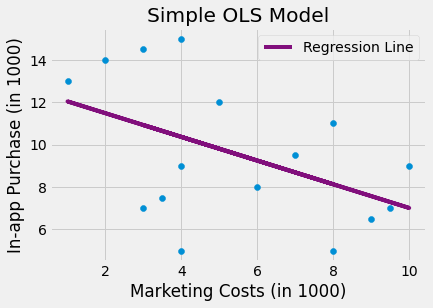

In [11]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

이제 여러분은 인과추론에 대해 많이 계시므로, 고정 효과 모델을 실행하기로 결정하고 도시의 지표를 모델에 더미변수로 추가합니다. 고정 효과 모델은 시간에 따라 일정한 도시 고유의 특성을 통제하므로, 도시가 여러분의 상품에 대해 덜 개방적이면 이를 포착하게 됩니다. 해당  모델을 돌리면, 마침내 여러분은 더 많은 마케팅 비용이 더 많은 인앱 구매로 이어진다는 것을 알 수 있게 됩니다.

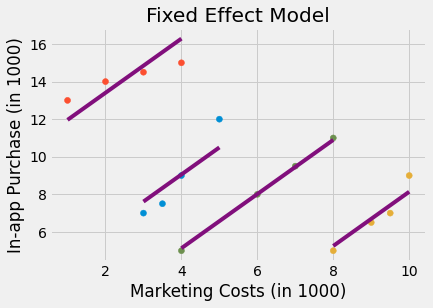

In [12]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

잠시 시간을 내서보면, 위의 그래프가 고정 효과가 어떤 역할을 하고 있는지 알려주고 있어요. 고정 효과는 **도시당 하나의 회귀선**을 적합(fitting)한다는 점과 적합된 회귀선이 평행하다는 점을 주목해주세요. 회귀선의 기울기는 인앱 구매에 대한 마케팅 비용의 효과입니다. 따라서 **고정 효과는 인과 효과가 모든 개체(이 예시에서는 도시)**에 걸쳐 일정하다고 가정합니다. 이러한 가정은 관점에 따라 약점이 될 수도 있고 장점이 될 수도 있습니다. 만약, 여러분이 도시별 인과효과를 추정하는데 관심이 있다면 약점이 될 수 있어요. 고정 효과 모델은 해당 효과가 개체(도시)간에 일정하다고 가정하기 때문에, 도시에 따른 인과효과 차이를 찾지 못할 거에요. 그런데, 인앱 구매에 대한 마케팅의 전반적인 효과를 찾으려고 한다면, 해당 데이터의 패널 형태가 고정 효과를 탐색할 수 있게 도움을 줍니다.

## Time Effects

개별 수준에 대해 고정 효과를 수행한 것처럼, 시간 수준에 대해서도 고정 효과를 설계할 수 있어요. 만약 고정된 개별 특성에 대한 개별 더미변수를 추가한다면, 시간 더미를 추가하는 것은 각 기간 동안 고정되는 변수들에 대해 통제를 할 수 있지만, 시간이 지남에 따라 바뀔 수 있어요. 해당 변수의 한 예시는 인플레이션이에요. 물가와 급여는 시간이 지남에 따라 상승하는 경향이 있으나, 각 기간의 인플레이션은 모든 개체에서 동일합니다. 조금 더 구체적인 예를 들자면, 결혼이 시간이 지남에 따라 증가하고 있다고 가정해 봅시다. 임금과 결혼 비중도 시간이 지남에 따라 변한다면, 시간은 교란 변수로 볼 수 있게됩니다. 인플레이션은 또한 시간이 지남에 따라 급여를 증가시킬 수 있으므로, 결혼과 급여 사이에 긍정적인 연관성이 있는 것은 단순히 시간이 지남에 따라 두 가지 변수가 모두 증가하기 때문일 거에요. 해당 교란효과를 보정하기 위해 각 기간에 대한 더미 변수를 추가할 수 있습니다. 패키지 'linearmodels'에서는 수식에 'TimeEffects'를 추가하고 'cluster_time'을 true로 설정할 수 있어서, 매우 간단하게 해결할 수 있어요.

In [13]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05


위의 새로운 모델에서는 결혼이 임금에 미치는 영향이 '0.1147'에서 '0.0476'으로 크게 감소했어요. 그래도 해당 결과는 99% 신뢰 수준에서 유의미하므로 남자는 여전히 결혼으로 인한 수입 증가를 기대할 수 있습니다.

## When Panel Data Won't Help You

패널 데이터와 고정 효과 모델을 활용하는 것은 인과추론을 위한 매우 강력한 도구입니다. 랜덤 데이터나 인과추론을 위한 마땅한 방법이 없을 때, 고정 효과는 비실험 데이터(non-experimental)로 인과추론을 할 때만큼 설득력이 존재합니다. 그래도 언제나 적용될 수 있는 만병 통치약은 아닙니다. 패널 데이터조차 도움이 되지 않는 상황이 있기 마련이에요.

가장 분명한 것은 시간이 지남에 따라 변하는 교란변수가 있을 때입니다. 고정 효과는 각 대상의 일정한 속성에 대해서만 편향을 제거할 수 있어요. 예를 들면, 책을 읽고 많고 좋은 지방을 섭취함으로써 지능을 높일 수 있다고 가설을 세워봅시다. 그러면, 이렇게 지능을 높이는 요소가 여러분이 고소득 직업과 아내를 얻을 수 있게해요. 고정 효과는 관측되지 않은 교란변수(지능)로 인해, 해당 편향을 제거할 수 없습니다. 왜냐하면, 해당 예시에서 지능은 시간에 따라 변하기 때문이죠.

![img](./data/img/fixed-effects/time-travel.png)

고정 효과가 실패하는 또 다른 경우는 **역인과관계**가 있는 경우입니다. 예를 들어, 더 많은 돈을 벌게 하는 것은 결혼이 아니라고 가정해봅시다. 더 많이 버는 것은 여러분이 결혼할 확률을 높이고 있어요. 이 경우 양의 상관관계가 있는 것처럼 보이지만 수입이 먼저임을 알 수 있습니다. 해당 변수들은 시간에 따라 같은 방향으로 변할 것이므로, 고정 효과로는 시간에 변화에 대한 통제를 할 수 없습니다.

## Key Ideas

이번 챕터에서 우리는 여러 기간에 걸쳐 동일한 대상에 대해 여러 측정값이 있는 데이터인 패널 데이터를 사용하는 방법을 살펴보았습니다. 이 경우 개체(entity)를 제어하는 ​​고정 효과 모델을 사용해, 모든 대상과 시간이 변하지 않는 변수를 고정할 수 있습니다. 고정 효과 모델은 교란변수를 통제하는 ​​강력하고 매우 설득력 있는 방법이며 랜덤이 아닌 데이터를 사용하는 것만큼이나 효과가 좋습니다.

마지막으로 우리는 고정 효과 모델이 인과추론의 만병통치약이 아님을 확인해 볼 수 있었습니다. 고정 효과가 잘 작동하지 않는 두 예시를 확인했어요: 역인과관계가 있을 때와 관측되지 않은 교란변수가 시간에 따라 변할 때입니다.


## References

저는 이 책을 Joshua Angrist, Alberto Abadie 및 Christopher Walters의 대단한 계량 경제학 수업에 대한 찬사라고 생각하고 싶습니다. 이 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 지켜보는 것이 저의 2020년의 힘든 한 해 동안, 온전한 정신을 유지하도록 도와주었어요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)


또한 Angrist의 정말 좋은 책들을 참고자료 목록에 담고 싶습니다. 이 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 재미있다는 것을 저에게 보여주었습니다.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

제가 참고한 또다른 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자와 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

마지막으로, Scott Cunningham과 인과 추론과 Mixtape 형태를을 결합한 그의 훌륭한 작업에도 찬사를 보냅니다.

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)


## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 지적으로 접근이 가능할 수 있도록 하는 것이 목표입니다. 그리고, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/matheusfacure/python-causality-handbook/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [이 책의 Github 자료에 star](https://github.com/matheusfacure/python-causality-handbook/stargazers) 부탁드립니다!